# Práctica 3. Optimización de un modelo de ingeniería usando un algoritmo genético

A menudo, en ingeniería tenemos simulaciones de un modelo y hay que optimizar sus parámetros sin disponer de una fórmula explícita que relacione los parámetros con el comportamiento del modelo. Nos plantearemos un problema de ese tipo: tenemos una función que calcula las propiedades de una hélice en función de una serie de parámetros, pero no conocemos los cálculos que hace internamente. Disponemos de una caja negra que es un modelo de simulación (créditos: Siro Moreno y Carlos Dorado)

Aunque no es imprescindible conocer todos los detalles del modelo sí es recomendable familiarizarnos con los parámetros de configuración de la hélice que vamos a optimizar. 

In [28]:
#Sergio Martínez Olivera y Daniel Roldán Serrano
from modelo.helice import *
import math

In [2]:
help(calcular_helice)

Help on function calcular_helice in module modelo.helice:

calcular_helice(omega, vz, R, b, h=0, theta0=0.174, tors_param=['h', 14], chord_params=0.05)
    Calcula las propiedades de una hélice.

    Argumentos obligatorios:

        - omega: velocidad de giro de la hélice, en rad/s
        - vz: velocidad de avance, en m/s
        - R : radio de la hélice
        - b : número de palas

    Argumentos opcionales:

        - h : altitud de vuelo, en metros sobre el nivel del mar
        - theta0 : ángulo de paso colectivo
        - tors_param : parámetros de torsión de la hélice:
            formato: [ley, p]
                p: Parámetro: número o lista
                Ley:describe la forma de la ley de torsiones, y puede ser:
                    - 'c': distribución de torsión constante = p
                    - 'l': distribución de torsión lineal, con p[0] en la raíz y p[1] en la punta
                    - 'h': distribución de torsión hiperbólica, con torsión p en la punta
        - c

Lo primero que tendrás que hacer es definir una representación adecuada para los cromosomas que representan un diseño de la hélice en base a sus parámetros. Nuestra hélice depende de varios parámetros que queremos optimizar. Podemos decidir optimizar algunos mateniendo un valor controlado de otros. 

***Como sugerencia*** se proponen los siguientes parámetros de optimización: 

- omega (velocidad de rotación) (Entre 0 y 200 radianes/segundo)
- R (radio de la hélice) (Entre 0.1 y 2 metros)
- b (número de palas) (Entre 2 y 5 palas) 
- theta0 (ángulo de paso colectivo) (Entre -0.26 y 0.26 radianes)(*se corresponde a -15 y 15 grados*)
- p (parámetro de torsión) (Entre -5 y 20 grados)
- cuerda (anchura de la pala) (Entre 0.01 y 0.2 metros)

y fijar los parámetros:
- vz (velocidad de vuelo)
- h (altura de vuelo)

Ten en cuenta que necesitarás funciones de decodificación hay que transformar la representación binaria en variables con sentido físico. Por ejemplo, si el entero de la variable Omega está entre 0 y 1023 (10bits), pero la variable Omega real estará entre 0 y 200 radianes por segundo, el valor se calcula como:
    omega = genes[0] * 200 / 1023
    
del mismo modo, para R:
    R =  0.1 + genes[1] * 1.9 / 1023 #Obtendremos un radio entre 0.1 y 2 metros
    
El número de palas debe ser un entero:
    b = genes[2] + 2 #(entre 2 y 5 palas)
    
    
Para la función de fitness usaremos la función que calcula el desempeño del rotor según sus parámetros:

    T, P, efic, mach_punta = calcular_rotor(omega, vz, R, b, h...) #Introduce las variables que uses de parámetro.
                                                                # Consulta la ayuda para asegurarte de que usas el 
                                                                # formato correcto!
Recuerda que T es la tracción de la hélice, P es la Potencia consumida por la hélice, efic representa la eficiencia propulsiva de la hélice y mach_punta representa el mach en la punta de las palas. El número de mach en las puntas de la hélice se refiere a la velocidad relativa de las puntas de la hélice con respecto a la velocidad del sonido en el aire circundante.

Antes de seguir vamos a observar en las gráficas cómo cambian las características de la hélice (tracción, potencia, eficiencia y mach de las puntas) para cada valor de velocidad de vuelto (avance en m/s). Fijamos unos ciertos parámetros para ver el desempeño de la hélice.    

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [4]:
vel = np.linspace(0, 30, 100)
h = np.linspace(0, 100, 100)
# La función linspace() devuelve 100 valores espaciados uniformemente dentro del intervalo especificado [0, ] 
# zeros_like return an array of zeros with the same shape and type as a given array.
efic = np.zeros_like(vel)
T = np.zeros_like(vel)
P = np.zeros_like(vel)
mach = np.zeros_like(vel)
for i in range(len(vel)):
    T[i], P[i], efic[i], mach[i] = calcular_helice(130, vel[i], 0.5, 3)

Text(0.5, 1.0, 'Eficiencia de la hélice')

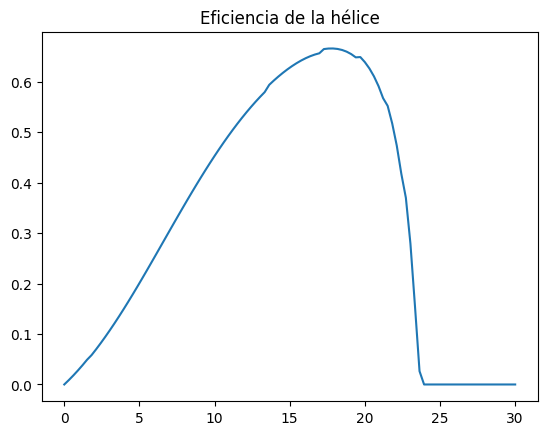

In [5]:
plt.plot(vel, efic)
plt.title('Eficiencia de la hélice')

Text(0.5, 1.0, 'Tracción de la hélice')

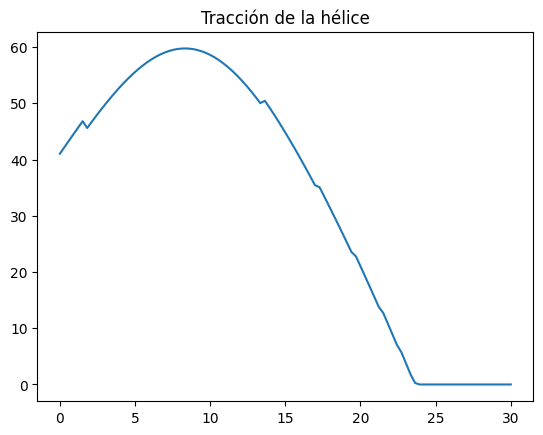

In [6]:
plt.plot(vel, T)
plt.title('Tracción de la hélice')

Text(0.5, 1.0, 'Potencia consumida')

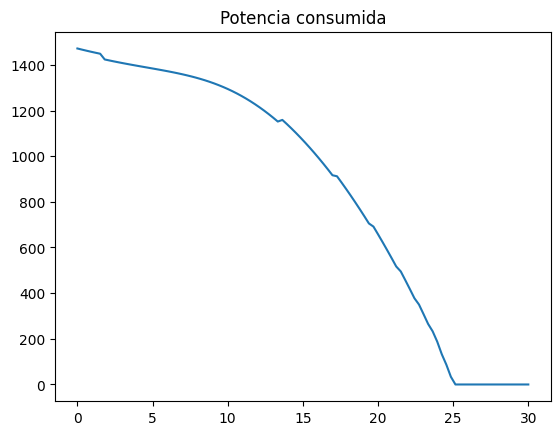

In [7]:
plt.plot(vel, P)
plt.title('Potencia consumida')

Text(0.5, 1.0, 'Mach en la punta de las palas')

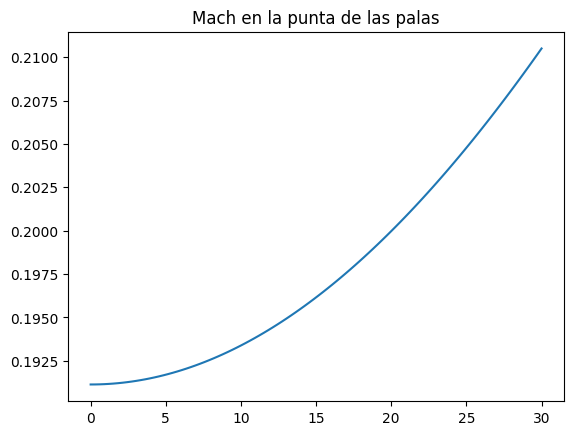

In [8]:
plt.plot(vel, mach)
plt.title('Mach en la punta de las palas')

In [9]:
#Observando las gráficas, podemos deducir que un valor adecuado para fijar la velocidad de vuelo (como se recomienda en el enunciado) puede ser 15 m/s.

Si quieres puedes observar también el impacto del resto de parámetros. 

Para la ejecución del algoritmo tendrás que definir una **función de fitness** adecuada según lo que decidas optimizar.

Por ejemplo, si buscáramos que tuviera la tracción máxima sin preocuparnos de nada más, el valor de fitnes sería simplemente igual al de T:

    fitness = T

Si queremos imponer restricciones, por ejemplo, que la potencia sea menor a 1000 watios, se pueden añadir sentencias del tipo:

    if P > 1000:
        fitness -= 1000
        
Si queremos optimizar varias salidas podemos hacerlo de manera ponderada:

    fitness = parámetro_importante * 10 + parámetro_poco_importante * 0.5
    
También se pueden combinar diferentes funciones no lineales:

    fitness = parámetro_1 * parámetro_2 - parámetro_3 **2 * log(parámetro_4)

Puedes elegir con qué objetivo quieres optimizar la hélice pero te hacemos algunas sugerencias de posibles objetivos de optimización:

    - Maximizar la tracción (manteniendo una tracción mínima de 30 Newtons) con el mínimo radio posible.
    - Mínima potencia consumida posible, máxima eficiencia propulsiva, y mínimo radio posible (sin ser este criterio muy importante), manteniendo una tracción mínima de 40 Newtons y un mach en la punta de las palas de como mucho 0.7
    - Máximizar la eficiencia cuando vuela a 70 m/s, y maximizar la tracción por encima de 50 Newtons para el despegue (vz = 0)    

### Se pide utilizar un algoritmo genético para encontrar la mejor configuración de parámetros para el modelo de hélice dado y comentar los resultados obtenidos. 

Documentar convenientemente el código y justificar las decisiones para la configuración del algoritmo genético. 

In [121]:
"""Argumentos obligatorios:

        - omega: velocidad de giro de la hélice, en rad/s
        - vz: velocidad de avance, en m/s
        - R : radio de la hélice
        - b : número de palas

    Argumentos opcionales:

        - h : altitud de vuelo, en metros sobre el nivel del mar
        - theta0 : ángulo de paso colectivo
        - tors_param : parámetros de torsión de la hélice:
            formato: [ley, p]
                p: Parámetro: número o lista
                Ley:describe la forma de la ley de torsiones, y puede ser:
                    - 'c': distribución de torsión constante = p
                    - 'l': distribución de torsión lineal, con p[0] en la raíz y p[1] en la punta
                    - 'h': distribución de torsión hiperbólica, con torsión p en la punta
        - chord_params : parámetros de distribución de cuerda de la hélice.
          Describe la forma de la pala, y puede ser:
            - un número float: la cuerda es constante, con ese valor en metros
            - una lista de la forma ['l', x1, x2 ]:
                La cuerda es lineal con la posición, y mide x1 m en la raíz y x2 m en la punta
    Devuelve:

        - T : tracción de la hélice, en Newtons
        - P : potencia de la hélice, en Watios
        - efic : eficiencia o rendimiento de la hélice (a v=0 es 0 por definición)
        - mach_punta : número de mach de las puntas de la hélice

        en en cuenta que necesitarás funciones de decodificación hay que transformar la representación binaria en variables con sentido físico. Por ejemplo, si el entero de la variable Omega está entre 0 y 1023 (10bits), pero la variable Omega real estará entre 0 y 200 radianes por segundo, el valor se calcula como: omega = genes[0] * 200 / 1023

del mismo modo, para R: R = 0.1 + genes[1] * 1.9 / 1023 #Obtendremos un radio entre 0.1 y 2 metros

El número de palas debe ser un entero: b = genes[2] + 2 #(entre 2 y 5 palas)

Para la función de fitness usaremos la función que calcula el desempeño del rotor según sus parámetros:

T, P, efic, mach_punta = calcular_rotor(omega, vz, R, b, h...) #Introduce las variables que uses de parámetro.
                                                            # Consulta la ayuda para asegurarte de que usas el 
                                                            # formato correcto!

Recuerda que T es la tracción de la hélice, P es la Potencia consumida por la hélice, efic representa la eficiencia propulsiva de la hélice y mach_punta representa el mach en la punta de las palas. El número de mach en las puntas de la hélice se refiere a la velocidad relativa de las puntas de la hélice con respecto a la velocidad del sonido en el aire circundante.

Antes de seguir vamos a observar en las gráficas cómo cambian las características de la hélice (tracción, potencia, eficiencia y mach de las puntas) para cada valor de velocidad de vuelto (avance en m/s). Fijamos unos ciertos parámetros para ver el desempeño de la hélice. 
        
        
        
        
        """


class ProblemaGeneticoHelice(object):
        def __init__(self,fun_dec,fun_muta , fun_cruza, fun_fitness):
            self.fun_dec = fun_dec
            self.fun_cruza = fun_cruza
            self.fun_muta = fun_muta
            self.fun_fitness = fun_fitness
                
        def decodifica(self, genotipo):
            """Devuelve el fenotipo a partir del genotipo"""
            fenotipo = self.fun_dec(genotipo)
            return fenotipo
        
        def muta(self, cromosoma,prob):
            """Devuelve el cromosoma mutado"""   
            mutante = self.fun_muta(cromosoma,prob)
            return mutante
        
        def cruza(self, cromosoma1, cromosoma2):         
            """Devuelve el cruce de un par de cromosomas"""
            cruce = self.fun_cruza(cromosoma1,cromosoma2)
            return cruce 
        
        def fitness(self, cromosoma):    
            """Función de valoración"""
            valoracion = self.fun_fitness(cromosoma)
            return valoracion


def decodificacion(genes): #Decodificación genérica (velocidad de avance fijada 15 y altura por defecto, fijada a 0)
    fenotipo = []
    fenotipo.append(genes[0] * (200 / 1023)) ##omega (velocidad de rotación)
    fenotipo.append(15) ##vz (velocidad de avance)
    fenotipo.append(0.1 + ((genes[2] * 1.9) / 1023)) ##R (radio de la hélice)
    fenotipo.append(2 + math.trunc((genes[3]*3)/1023)) ##número palas 
    fenotipo.append(0) ##h (altura de vuelo)
    fenotipo.append(-15 + ((genes[5]*30)/1023)) ##theta0   (angulo de paso colectivo)          pasar la división a entero???
    fenotipo.append(-5 + ((genes[6]*25)/1023)) ##p (parámetro de torsión)
    fenotipo.append(0.01 + ((genes[7]*0.19)/1023)) ##cuerda (anchura de la pala)
    return fenotipo

def decodificacion_despegue(genes): #Decodificación para el despegue (velocidad de avance fijada a 0)
    fenotipo = []
    fenotipo.append(genes[0] * (200 / 1023)) ##omega (velocidad de rotación)
    fenotipo.append(0) ##vz (velocidad de avance)
    fenotipo.append(0.1 + ((genes[2] * 1.9) / 1023)) ##R (radio de la hélice)
    fenotipo.append(2 + math.trunc((genes[3]*3)/1023)) ##número palas 
    fenotipo.append(0) ##h (altura de vuelo)
    fenotipo.append(-15 + ((genes[5]*30)/1023)) ##theta0   (angulo de paso colectivo)          pasar la división a entero???
    fenotipo.append(-5 + ((genes[6]*25)/1023)) ##p (parámetro de torsión)
    fenotipo.append(0.01 + ((genes[7]*0.19)/1023)) ##cuerda (anchura de la pala)
    return fenotipo

def decodificacion_70(genes): #Decodificación a 70 m/s (velocidad de avance fijada a 70 m/s)
    fenotipo = []
    fenotipo.append(genes[0] * (200 / 1023)) ##omega (velocidad de rotación)
    fenotipo.append(70) ##vz (velocidad de avance)
    fenotipo.append(0.1 + ((genes[2] * 1.9) / 1023)) ##R (radio de la hélice)
    fenotipo.append(2 + math.trunc((genes[3]*3)/1023)) ##número palas 
    fenotipo.append(0) ##h (altura de vuelo)
    fenotipo.append(-15 + ((genes[5]*30)/1023)) ##theta0   (angulo de paso colectivo)          pasar la división a entero???
    fenotipo.append(-5 + ((genes[6]*25)/1023)) ##p (parámetro de torsión)
    fenotipo.append(0.01 + ((genes[7]*0.19)/1023)) ##cuerda (anchura de la pala)
    return fenotipo

def fitness1(cromosoma): ##Maximizar la tracción (manteniendo una tracción mínima de 30 Newtons) con el mínimo radio posible.
    aux = decodificacion(cromosoma)
    T, P, efic, mach_punta = calcular_helice(aux[0], aux[1], aux[2], aux[3], aux[4], aux[5], ['h', aux[6]], aux[7])
    if T < 30:
        return -1000
    else:
        return T - 1400*aux[2] ##Queremos maximizar la tracción (de ahí sumar T) y minimizar el radio (de ahí restar aux[2] = R) para que la función
                            ##de fitness sea lo mayor posible cuanto mayor sea la tracción y menor sea el radio. Otorgamos la misma importancia a la optimización de ambos parámetros.


def fitness2(cromosoma): ##Maximizar la eficiencia cuando vuela a 70 m/s, y maximizar la tracción por encima de 50 Newtons para el despegue (vz = 0)    
    aux = decodificacion(cromosoma)
    T1, P1, efic1, mach_punta1 = calcular_helice(aux[0], 70, aux[2], aux[3], aux[4], aux[5], ['h', aux[6]], aux[7]) ##Fijamos la velocidad de avance a 70 m/s
    T2, P2, efic2, mach_punta2 = calcular_helice(aux[0], 0, aux[2], aux[3], aux[4], aux[5], ['h', aux[6]], aux[7]) ##Fijamos la velocidad de avance a 0 m/s, es decir, el momento del despegue

    if (T2 < 50):
        return -1000
    else:
        return efic1 + T2 ##Sumamos la eficacia obtenida al volar a 70 m/s con la tracción obtenida en el despegue, a 0 m/s, dado que queremos maximizar ambos.

def muta1(cromosoma, prob):
    #Elegimos un parámetro del cromosoma
    l = len(cromosoma)
    p = random.randint(0,l-1)
    
    #Si la probabilidad es favorable, el parámetro se divide entre 2 (para no salirnos de su rango de valores)
    if prob > random.uniform(0,1):
            cromosoma[p]= cromosoma[p]/2
    return cromosoma
    

def muta2(cromosoma, prob):
    #Elegimos dos parámetros del cromosoma
    l = len(cromosoma)
    p1 = random.randint(0,l-1)
    p2 = random.randint(0,l-1)
    
    #Queremos que los parámetros sean distintos
    while p1==p2:
        p2 = random.randint(0,l-1)
    
    #Si la probabilidad es favorable, dividimos entre 2 ambos parámetros
    if prob > random.uniform(0,1):
        cromosoma[p1]= cromosoma[p1]/2
        cromosoma[p2]= cromosoma[p2]/2
    return cromosoma


#Funcion de cruze por orden
def cruzarOrden(cromosoma1, cromosoma2):
    l = len(cromosoma1)
    p1 = random.randint(0,l-1) #Elegimos el primer punto
    p2 = random.randint(p1,l-1) #Elegimos el segundo punto
    #Realizamos los dos cruces
    cruzar1 = orden(cromosoma1,cromosoma2,p1,p2)
    cruzar2 = orden(cromosoma2,cromosoma1,p1,p2)
    return [cruzar1,cruzar2]

def orden(cP,cH,p1,p2):
    salida =[]
    for _ in range(len(cP)):
        salida.append(0)
    
    for i in range(p1,p2+1):
        salida[i]=cP[i]
        
    index=p2+1
    indexcH=p2+1
    while salida[index%len(salida)]==0:
        while cH[indexcH%len(cH)] in salida:
            indexcH+=1
        salida[index%len(salida)]=cH[indexcH%len(cH)]
        index+=1
        
    return salida
    

In [59]:
def poblacion_inicial(size):
    l=[] # población inicial
    for i in range(size): # añadimos a la población size individuos
        j = 0
        cromosoma = []
        #Construimos cada cromosoma otorgando a los 8 parámetros que necesitamos un valor aleatorio entre 0 y 1024.
        while j < 8:
            cromosoma.append(random.randint(0,1023))
            j = j + 1
        l.append(cromosoma) #Añadimos el cromosoma a la lista de la población inicial.
    return l

#Funcion que craza los padres de forma NO destructiva, es decir se queda con los dos mejores entre los hijos y los padres
def cruza_padres_NO_destructiva(problema_genetico,padres):
    l = []
    for i in range(len(padres)//2):
        padre1=padres[2*i]
        padre2=padres[2*i+1]
        desc = problema_genetico.cruza(padre1,padre2)
        
        lista = [padre1,padre2,desc[0],desc[1]]
        
        mejores=sorted(lista,key=problema_genetico.fitness,reverse=True)
        
        l.append(mejores[0]) 
        l.append(mejores[1])
    return l

#Función para llevar a cabo las mutaciones
def muta_individuos(problema_genetico, poblacion, prob):
    l = []
    for i in poblacion:
        l.append(problema_genetico.muta(i,prob))
    return l

#Función para llevar a cabo la selección
def seleccion_por_torneo(problema_genetico, poblacion, n, k, opt):
    seleccionados = []
    for i in range(n):
        participantes = random.sample(poblacion,k)
        seleccionado = opt(participantes, key=problema_genetico.fitness)
        opt(poblacion, key=problema_genetico.fitness)
        seleccionados.append(seleccionado)
    return seleccionados  

#Función para construir la nueva generación
def nueva_generacion(problema_genetico, k,opt, poblacion, n_padres, n_directos,cruza_padres,prob_mutar):
    padres2 = seleccion_por_torneo(problema_genetico, poblacion, n_directos, k,opt) 
    padres1 = seleccion_por_torneo(problema_genetico, poblacion, n_padres , k, opt)
    cruces =  cruza_padres(problema_genetico,padres1)
    generacion = padres2+cruces
    resultado_mutaciones = muta_individuos(problema_genetico, generacion, prob_mutar)
    return resultado_mutaciones

In [ ]:
def algoritmo_genetico(problema_genetico,k,opt,ngen,size,cruzar,prop_cruces,prob_mutar):
    poblacion= poblacion_inicial(size)
    n_padres=round(size*prop_cruces)
    n_padres= int (n_padres if n_padres%2==0 else n_padres-1)
    n_directos = size-n_padres
    for _ in range(ngen):
        poblacion= nueva_generacion(problema_genetico,k,opt,poblacion,n_padres, n_directos,cruzar,prob_mutar)

    mejor_cr= opt(poblacion, key=problema_genetico.fitness)
    mejor=problema_genetico.decodifica(mejor_cr)
    return (mejor,problema_genetico.fitness(mejor_cr), calcular_helice(mejor[0], mejor[1], mejor[2], mejor[3], mejor[4], mejor[5], ['h', mejor[6]], mejor[7])) 

In [ ]:
#Vamos a probar en primer lugar el correcto funcionamiento de cada fitness, cada uno con las dos mutaciones propuestas y con un cruce no destructivo, que como ya sabemos es más recomendable
#porque no permite empeorar.

In [129]:
helice = ProblemaGeneticoHelice(decodificacion,muta1,cruzarOrden,fitness1)              
salida = algoritmo_genetico(helice,5,max,6,100,cruza_padres_NO_destructiva,0.7,0.2)
print(f"Valor obtenido={salida[1]}\nSolucion Obtenida:\n{salida[0]}\nValores:\n{salida[2]}")


Valor obtenido=24313.22218954978
Solucion Obtenida:
[186.3147605083089, 15, 1.8439882697947214, 4, 0, 0.19061583577712682, 13.768328445747802, 0.18235581622678398]
Valores:
(26894.805767262387, 3801313.909484284, 0.10612701190038451, 1.0112059370882904)


In [130]:
helice = ProblemaGeneticoHelice(decodificacion,muta2,cruzarOrden,fitness1)              
salida = algoritmo_genetico(helice,5,max,6,100,cruza_padres_NO_destructiva,0.7,0.2)
print(f"Valor obtenido={salida[1]}\nSolucion Obtenida:\n{salida[0]}\nValores:\n{salida[2]}")
#Recordamos que fitness 1 pretende minimizar el radio y maximizar la tracción, y como se aprecia en ambas salidas, consigue en parte su objetivo.
#Por un lado, observamos que en la salida 2 la tracción es elevada, del orden de 10^4, luego, se maximiza adecuadamente. En la salida 1 la tracción también toma un valor elevado,
#pero del orden 10^3, algo menor que en el segundo caso. Sin embargo, el radio no se minimiza en ninguna de las dos salidas,
#dado que en ambos casos toma un valor cercano a 2, que es su límite superior. Esto se debe a que debido a que los valores que puede tomar el raadio son muy pequeños,
#el hecho de que tome valores elevados dentro de su rango no provoca que el fitness sea peor, dado que la tracción tma valores muy elevados. Hemos probado a 
#multiplicar el radio en la función de fitness por 100, 1000,10000, pero el algoritmo funcionaba incluso peor, dado que de esta manera el algoritmo no llegaba a los mínimos necesarios de tracción, a pesar de mninimizar el radio.

Valor obtenido=21400.06755242639
Solucion Obtenida:
[186.70576735092862, 15, 1.9312805474095796, 3, 0, -0.014662756598241344, 19.731182795698924, 0.19907135874877813]
Valores:
(24103.8603187998, 2943784.7905188953, 0.12282076663568396, 1.0612048138065047)


In [128]:
helice = ProblemaGeneticoHelice(decodificacion_despegue,muta1,cruzarOrden,fitness2)              
salida = algoritmo_genetico(helice,5,max,6,100,cruza_padres_NO_destructiva,0.7,0.2)
print(f"Valor obtenido={salida[1]}\nSolucion Obtenida:\n{salida[0]}\nValores:\n{salida[2]}")

Valor obtenido=42172.08022588857
Solucion Obtenida:
[177.32160312805473, 0, 1.992570869990225, 4, 0, 0.48387096774193594, -1.8352883675464322, 0.1983284457478006]
Valores:
(42171.565473992174, 4078648.2050427706, 0.0, 1.0389534391473474)


In [65]:
helice = ProblemaGeneticoHelice(decodificacion_70,muta2,cruzarOrden,fitness2)              
salida = algoritmo_genetico(helice,5,max,6,100,cruza_padres_NO_destructiva,0.7,0.2)
print(f"Valor obtenido={salida[1]}\nSolucion Obtenida:\n{salida[0]}\nValores:\n{salida[2]}")
#Recordamos que fitness 2 maximiza la potencia a 70 m/s y maximiza la tracción en el despegue, es decir, a 0 m/s.
#Observamos unos buenos resultados en ambas salidas, con buenos fitness, elevada potencia (del orden 10^6) con 70m/s y una tracción adecuada (orden 10^4) en el despegue. Utilizamos para la primera salida una decodificación que fija la velocidad a 0 y en la
#segunda de ellas una decodificación que fija la velocidad a 70.

Valor obtenido=44209.090561008365
Solucion Obtenida:
[192.1798631476051, 70, 1.936852394916911, 4, 0, 0.5131964809384169, -1.4015151515151514, 0.19238514173998048]
Valores:
(27939.08077351605, 3837161.704093648, 0.5096828867179772, 1.1137097868719985)


In [93]:
#Ahora, tomando, por ejemplo, el fitness1 y la mutación2 (más fuerte que mutación 1), vamos a observar la influencia de otorgar una mayor probabilidad de mutación.
helice = ProblemaGeneticoHelice(decodificacion,muta2,cruzarOrden,fitness1)              
salida = algoritmo_genetico(helice,5,max,6,100,cruza_padres_NO_destructiva,0.7,0.8) #Ponemos 80% de mutación
print(f"Valor obtenido={salida[1]}\nSolucion Obtenida:\n{salida[0]}\nValores:\n{salida[2]}")
#Observamos que no se consigue el fitness deseado por fitness1, dado que el fitness obtenido es relativamente bajo, comparado con los obtenidos anterioremente (alrdedor de 30000),
#debido a un radio bastante elevado y a una tracción no tan elevada como podría ser (en casos anteriores rondaba 30000 y ahora es de 5000). De esto podemos deducir que una mayor probabilidad de mutación
#no es recomendable para alcanzar el cromosoma óptimo.

Valor obtenido=5388.599449229335
Solucion Obtenida:
[81.42717497556207, 15, 1.89227761485826, 4, 0, 0.4252199413489741, 0.8528836754643203, 0.15951124144672532]
Valores:
(5390.491726844193, 237911.6217744731, 0.3398630773040216, 0.4552218587825476)


In [94]:
#A continuación, vamos a observar la influencia de otorgar una mayor presión de torneo con el fitness2 (codificación de despegue).
helice = ProblemaGeneticoHelice(decodificacion_despegue,muta1,cruzarOrden,fitness3)              
salida = algoritmo_genetico(helice,25,max,6,100,cruza_padres_NO_destructiva,0.7,0.3) #Ponemos una presión de torneo de 25 (muy elitista)
print(f"Valor obtenido={salida[1]}\nSolucion Obtenida:\n{salida[0]}\nValores:\n{salida[2]}")
#Como se observa en la salida, el algoritmo ni siquiere consigue la tracción mínima en el despegue, de ahí que el fitness sea -1000. Podríamos extrañarnos ante esto, ya que en cada torneo 
#tomamos los mejores cromosomas, pero como ya hemos visto en clase, los cruces con una selección  elitista no garantizan unos resultados óptimos, dado que un cruce de un cromosoma con poco fitness 
#con otro con buen fitness puede generar cromosomas con mayor fitness que al cruzar dos cromosomas con buen fitness, de ahí que no sea recomendable seguir una política de selección demasiado elitista, si no que
#hay que intentar que en los cruces aparezcan cromosomas no tan buenos.

Valor obtenido=-1000
Solucion Obtenida:
[169.50146627565982, 0, 1.0295698924731183, 2, 0, -13.137829912023461, 7.426686217008797, 0.021654447702834798]
Valores:
(0, 0, 0, 0.5131566396958686)


In [99]:
#Finalmente, vamos a observar el efecto de aumentar el número de generaciones.
helice = ProblemaGeneticoHelice(decodificacion,muta1,cruzarOrden,fitness1)               
salida = algoritmo_genetico(helice,5,max,10,100,cruza_padres_NO_destructiva,0.7,0.3) #Ponemos 10 generaciones.
print(f"Valor obtenido={salida[1]}\nSolucion Obtenida:\n{salida[0]}\nValores:\n{salida[2]}")
#Observamos que aumentar el número de generaciones ha tenido un buen efecto sobre los resultados, como era de esperar. El radio sigue sin minimizarse, por
#la razón expuesta cuando probamos fitness 1, pero la tracción es más alta que en los dos casos probados con fitness 1, luego, el cromosoma óptimo no ha empeorado con las generaciones 
#7 a la 10. Esto se debe en parte a que los cruces son no destructivos, lo cual implica que en la nueva generación el cromosoma óptimo o bien es el mismo o bien mejor que en la anterior genración 
#(salvo que las mutaciones tengan un efecto negativo).

Valor obtenido=26827.154373403606
Solucion Obtenida:
[196.48093841642228, 15, 1.847702834799609, 4, 0, 0.5131964809384169, -0.5400782013685239, 0.13889540566959924]
Valores:
(26829.002076238405, 3938490.187003076, 0.10218002636431649, 1.0684239129578572)
